## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora)

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started

In [2]:
%pip install -U \
  torch==2.0.1 \
  accelerate==0.24.1 \
  transformers==4.35.2 \
  torchvision==0.15.2 \
  diffusers==0.23.1 \
  xformers==0.0.21 \
  bitsandbytes==0.41.1 \
  peft==0.6.2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Dataset

In [3]:
local_dir = "./images_dreambooth"

Preview the images:

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

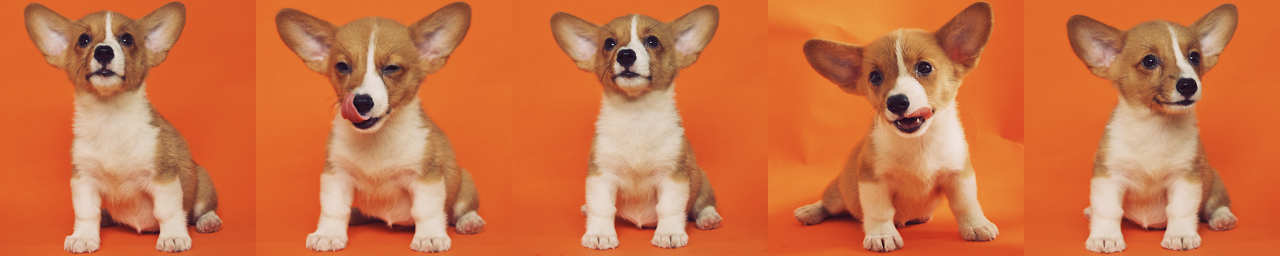

In [5]:
import glob

imgs = [Image.open(path) for path in glob.glob("./images_dreambooth/*.jpeg")]
image_grid(imgs, 1, 5)

# Train

In [6]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import shutil
import warnings
from pathlib import Path
from typing import Dict

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import LoraLoaderMixin, text_encoder_lora_state_dict
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnProcessor2_0
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version #, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available


# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
# check_min_version("0.22.0.dev0")

logger = get_logger(__name__)

def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")


In [7]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default="stabilityai/stable-diffusion-xl-base-1.0",
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--pretrained_vae_model_name_or_path",
    type=str,
    default="madebyollin/sdxl-vae-fp16-fix",
    help="Path to pretrained VAE model with better numerical stability. More details: https://github.com/huggingface/diffusers/pull/4038.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help="Revision of pretrained model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--instance_data_dir",
    type=str,
    default="images_dreambooth/",
    help="A folder containing the training data of instance images.",
)
parser.add_argument(
    "--class_data_dir",
    type=str,
    default=None,
    required=False,
    help="A folder containing the training data of class images.",
)
parser.add_argument(
    "--instance_prompt",
    type=str,
    default="a photo of Molly dog",
    help="The prompt with identifier specifying the instance",
)
parser.add_argument(
    "--class_prompt",
    type=str,
    default=None,
    help="The prompt to specify images in the same class as provided instance images.",
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    help="A prompt that is used during validation to verify that the model is learning.",
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images that should be generated during validation with `validation_prompt`.",
)
parser.add_argument(
    "--validation_epochs",
    type=int,
    default=50,
    help=(
        "Run dreambooth validation every X epochs. Dreambooth validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`."
    ),
)
parser.add_argument(
    "--with_prior_preservation",
    default=False,
    action="store_true",
    help="Flag to add prior preservation loss.",
)
parser.add_argument("--prior_loss_weight", type=float, default=1.0, help="The weight of prior preservation loss.")
parser.add_argument(
    "--num_class_images",
    type=int,
    default=100,
    help=(
        "Minimal class images for prior preservation loss. If there are not enough images already present in"
        " class_data_dir, additional images will be sampled with class_prompt."
    ),
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="dreambooth_lora_model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=1024,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--crops_coords_top_left_h",
    type=int,
    default=0,
    help=("Coordinate for (the height) to be included in the crop coordinate embeddings needed by SDXL UNet."),
)
parser.add_argument(
    "--crops_coords_top_left_w",
    type=int,
    default=0,
    help=("Coordinate for (the height) to be included in the crop coordinate embeddings needed by SDXL UNet."),
)
parser.add_argument(
    "--center_crop",
    default=False,
    action="store_true",
    help=(
        "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
        " cropped. The images will be resized to the resolution first before cropping."
    ),
)
parser.add_argument(
    "--train_text_encoder",
    action="store_true",
    help="Whether to train the text encoder. If set, the text encoder should be float32 precision.",
)
parser.add_argument(
    "--train_batch_size", type=int, default=2, help="Batch size (per device) for the training dataloader."
)
parser.add_argument(
    "--sample_batch_size", type=int, default=4, help="Batch size (per device) for sampling images."
)
parser.add_argument("--num_train_epochs", type=int, default=1)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=200,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=717,
    help=(
        "Save a checkpoint of the training state every X updates. These checkpoints can be used both as final"
        " checkpoints in case they are better than the last checkpoint, and are also suitable for resuming"
        " training using `--resume_from_checkpoint`."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=("Max number of checkpoints to store."),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=2,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=1e-4,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps", 
    type=int, 
    default=0, 
    help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument(
    "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")

parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default="fp16",
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
        " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
    ),
)
parser.add_argument(
    "--prior_generation_precision",
    type=str,
    default=None,
    choices=["no", "fp32", "fp16", "bf16"],
    help=(
        "Choose prior generation precision between fp32, fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to  fp16 if a GPU is available else fp32."
    ),
)
parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
parser.add_argument(
    "--enable_xformers_memory_efficient_attention",
    action="store_true", 
    help="Whether or not to use xformers."
)
parser.add_argument(
    "--rank",
    type=int,
    default=4,
    help=("The dimension of the LoRA update matrices."),
)

args, _ = parser.parse_known_args()

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.with_prior_preservation:
    if args.class_data_dir is None:
        raise ValueError("You must specify a data directory for class images.")
    if args.class_prompt is None:
        raise ValueError("You must specify prompt for class images.")
else:
    # logger is not available yet
    if args.class_data_dir is not None:
        warnings.warn("You need not use --class_data_dir without --with_prior_preservation.")
    if args.class_prompt is not None:
        warnings.warn("You need not use --class_prompt without --with_prior_preservation.")

print(args)

Namespace(pretrained_model_name_or_path='stabilityai/stable-diffusion-xl-base-1.0', pretrained_vae_model_name_or_path='madebyollin/sdxl-vae-fp16-fix', revision=None, instance_data_dir='images_dreambooth/', class_data_dir=None, instance_prompt='a photo of Molly dog', class_prompt=None, validation_prompt=None, num_validation_images=4, validation_epochs=50, with_prior_preservation=False, prior_loss_weight=1.0, num_class_images=100, output_dir='dreambooth_lora_model', seed=None, resolution=1024, crops_coords_top_left_h=0, crops_coords_top_left_w=0, center_crop=False, train_text_encoder=False, train_batch_size=2, sample_batch_size=4, num_train_epochs=1, max_train_steps=200, checkpointing_steps=717, checkpoints_total_limit=None, resume_from_checkpoint=None, gradient_accumulation_steps=2, gradient_checkpointing=False, learning_rate=0.0001, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=False, adam_beta1=0.9, a

In [8]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images.
    """

    def __init__(
        self,
        instance_data_root,
        class_data_root=None,
        class_num=None,
        size=1024,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            if class_num is not None:
                self.num_class_images = min(len(self.class_images_path), class_num)
            else:
                self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        instance_image = exif_transpose(instance_image)

        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            class_image = exif_transpose(class_image)

            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)

        return example


def collate_fn(examples, with_prior_preservation=False):
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    batch = {"pixel_values": pixel_values}
    return batch


class PromptDataset(Dataset):
    "A simple dataset to prepare the prompts to generate class images on multiple GPUs."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    return text_input_ids


# Adapted from pipelines.StableDiffusionXLPipeline.encode_prompt
def encode_prompt(text_encoders, tokenizers, prompt, text_input_ids_list=None):
    prompt_embeds_list = []

    for i, text_encoder in enumerate(text_encoders):
        if tokenizers is not None:
            tokenizer = tokenizers[i]
            text_input_ids = tokenize_prompt(tokenizer, prompt)
        else:
            assert text_input_ids_list is not None
            text_input_ids = text_input_ids_list[i]

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
        )

        # We are only ALWAYS interested in the pooled output of the final text encoder
        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds.hidden_states[-2]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds


def unet_attn_processors_state_dict(unet) -> Dict[str, torch.tensor]:
    """
    Returns:
        a state dict containing just the attention processor parameters.
    """
    attn_processors = unet.attn_processors

    attn_processors_state_dict = {}

    for attn_processor_key, attn_processor in attn_processors.items():
        for parameter_key, parameter in attn_processor.state_dict().items():
            attn_processors_state_dict[f"{attn_processor_key}.{parameter_key}"] = parameter

    return attn_processors_state_dict

In [9]:
logging_dir = Path(args.output_dir, args.logging_dir)

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Generate class images if prior preservation is enabled.
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < args.num_class_images:
        torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
        if args.prior_generation_precision == "fp32":
            torch_dtype = torch.float32
        elif args.prior_generation_precision == "fp16":
            torch_dtype = torch.float16
        elif args.prior_generation_precision == "bf16":
            torch_dtype = torch.bfloat16
        pipeline = StableDiffusionXLPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            torch_dtype=torch_dtype,
            revision=args.revision,
        )
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = args.num_class_images - cur_class_images
        logger.info(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

        sample_dataloader = accelerator.prepare(sample_dataloader)
        pipeline.to(accelerator.device)

        for example in tqdm(
            sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process
        ):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                hash_image = hashlib.sha1(image.tobytes()).hexdigest()
                image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                image.save(image_filename)

        del pipeline
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# Load the tokenizers
tokenizer_one = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision, use_fast=False
)
tokenizer_two = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer_2", revision=args.revision, use_fast=False
)

# import correct text encoder classes
text_encoder_cls_one = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder_2"
)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder_one = text_encoder_cls_one.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder_2", revision=args.revision
)
vae_path = (
    args.pretrained_model_name_or_path
    if args.pretrained_vae_model_name_or_path is None
    else args.pretrained_vae_model_name_or_path
)
vae = AutoencoderKL.from_pretrained(
    vae_path, subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None, revision=args.revision
)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# We only train the additional adapter LoRA layers
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
unet.requires_grad_(False)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move unet, vae and text_encoder to device and cast to weight_dtype
unet.to(accelerator.device, dtype=weight_dtype)

# The VAE is always in float32 to avoid NaN losses.
vae.to(accelerator.device, dtype=torch.float32)

text_encoder_one.to(accelerator.device, dtype=weight_dtype)
text_encoder_two.to(accelerator.device, dtype=weight_dtype)

if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder_one.gradient_checkpointing_enable()
        text_encoder_two.gradient_checkpointing_enable()

# now we will add new LoRA weights to the attention layers
# Set correct lora layers
unet_lora_attn_procs = {}
unet_lora_parameters = []
for name, attn_processor in unet.attn_processors.items():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_processor_class = (
        LoRAAttnProcessor2_0 if hasattr(F, "scaled_dot_product_attention") else LoRAAttnProcessor
    )
    module = lora_attn_processor_class(
        hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, rank=args.rank
    )
    unet_lora_attn_procs[name] = module
    unet_lora_parameters.extend(module.parameters())

unet.set_attn_processor(unet_lora_attn_procs)

# The text encoder comes from 🤗 transformers, so we cannot directly modify it.
# So, instead, we monkey-patch the forward calls of its attention-blocks.
if args.train_text_encoder:
    # ensure that dtype is float32, even if rest of the model that isn't trained is loaded in fp16
    text_lora_parameters_one = LoraLoaderMixin._modify_text_encoder(
        text_encoder_one, dtype=torch.float32, rank=args.rank
    )
    text_lora_parameters_two = LoraLoaderMixin._modify_text_encoder(
        text_encoder_two, dtype=torch.float32, rank=args.rank
    )

# create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
def save_model_hook(models, weights, output_dir):
    if accelerator.is_main_process:
        # there are only two options here. Either are just the unet attn processor layers
        # or there are the unet and text encoder atten layers
        unet_lora_layers_to_save = None
        text_encoder_one_lora_layers_to_save = None
        text_encoder_two_lora_layers_to_save = None

        for model in models:
            if isinstance(model, type(accelerator.unwrap_model(unet))):
                unet_lora_layers_to_save = unet_attn_processors_state_dict(model)
            elif isinstance(model, type(accelerator.unwrap_model(text_encoder_one))):
                text_encoder_one_lora_layers_to_save = text_encoder_lora_state_dict(model)
            elif isinstance(model, type(accelerator.unwrap_model(text_encoder_two))):
                text_encoder_two_lora_layers_to_save = text_encoder_lora_state_dict(model)
            else:
                raise ValueError(f"unexpected save model: {model.__class__}")

            # make sure to pop weight so that corresponding model is not saved again
            weights.pop()

        StableDiffusionXLPipeline.save_lora_weights(
            output_dir,
            unet_lora_layers=unet_lora_layers_to_save,
            text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
            text_encoder_2_lora_layers=text_encoder_two_lora_layers_to_save,
        )

def load_model_hook(models, input_dir):
    unet_ = None
    text_encoder_one_ = None
    text_encoder_two_ = None

    while len(models) > 0:
        model = models.pop()

        if isinstance(model, type(accelerator.unwrap_model(unet))):
            unet_ = model
        elif isinstance(model, type(accelerator.unwrap_model(text_encoder_one))):
            text_encoder_one_ = model
        elif isinstance(model, type(accelerator.unwrap_model(text_encoder_two))):
            text_encoder_two_ = model
        else:
            raise ValueError(f"unexpected save model: {model.__class__}")

    lora_state_dict, network_alphas = LoraLoaderMixin.lora_state_dict(input_dir)
    LoraLoaderMixin.load_lora_into_unet(lora_state_dict, network_alphas=network_alphas, unet=unet_)

    text_encoder_state_dict = {k: v for k, v in lora_state_dict.items() if "text_encoder." in k}
    LoraLoaderMixin.load_lora_into_text_encoder(
        text_encoder_state_dict, network_alphas=network_alphas, text_encoder=text_encoder_one_
    )

    text_encoder_2_state_dict = {k: v for k, v in lora_state_dict.items() if "text_encoder_2." in k}
    LoraLoaderMixin.load_lora_into_text_encoder(
        text_encoder_2_state_dict, network_alphas=network_alphas, text_encoder=text_encoder_two_
    )

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# Optimizer creation
params_to_optimize = (
    itertools.chain(unet_lora_parameters, text_lora_parameters_one, text_lora_parameters_two)
    if args.train_text_encoder
    else unet_lora_parameters
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

# Computes additional embeddings/ids required by the SDXL UNet.
# regular text emebddings (when `train_text_encoder` is not True)
# pooled text embeddings
# time ids

def compute_time_ids():
    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    original_size = (args.resolution, args.resolution)
    target_size = (args.resolution, args.resolution)
    crops_coords_top_left = (args.crops_coords_top_left_h, args.crops_coords_top_left_w)
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])
    add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
    return add_time_ids


if not args.train_text_encoder:
    tokenizers = [tokenizer_one, tokenizer_two]
    text_encoders = [text_encoder_one, text_encoder_two]

    def compute_text_embeddings(prompt, text_encoders, tokenizers):
        with torch.no_grad():
            prompt_embeds, pooled_prompt_embeds = encode_prompt(text_encoders, tokenizers, prompt)
            prompt_embeds = prompt_embeds.to(accelerator.device)
            pooled_prompt_embeds = pooled_prompt_embeds.to(accelerator.device)
        return prompt_embeds, pooled_prompt_embeds

# Handle instance prompt.
instance_time_ids = compute_time_ids()
if not args.train_text_encoder:
    instance_prompt_hidden_states, instance_pooled_prompt_embeds = compute_text_embeddings(
        args.instance_prompt, text_encoders, tokenizers
    )

# Handle class prompt for prior-preservation.
if args.with_prior_preservation:
    class_time_ids = compute_time_ids()
    if not args.train_text_encoder:
        class_prompt_hidden_states, class_pooled_prompt_embeds = compute_text_embeddings(
            args.class_prompt, text_encoders, tokenizers
        )

# Clear the memory here.
if not args.train_text_encoder:
    del tokenizers, text_encoders
    gc.collect()
    torch.cuda.empty_cache()

# Pack the statically computed variables appropriately. This is so that we don't
# have to pass them to the dataloader.
add_time_ids = instance_time_ids
if args.with_prior_preservation:
    add_time_ids = torch.cat([add_time_ids, class_time_ids], dim=0)

if not args.train_text_encoder:
    prompt_embeds = instance_prompt_hidden_states
    unet_add_text_embeds = instance_pooled_prompt_embeds
    if args.with_prior_preservation:
        prompt_embeds = torch.cat([prompt_embeds, class_prompt_hidden_states], dim=0)
        unet_add_text_embeds = torch.cat([unet_add_text_embeds, class_pooled_prompt_embeds], dim=0)
else:
    tokens_one = tokenize_prompt(tokenizer_one, args.instance_prompt)
    tokens_two = tokenize_prompt(tokenizer_two, args.instance_prompt)
    if args.with_prior_preservation:
        class_tokens_one = tokenize_prompt(tokenizer_one, args.class_prompt)
        class_tokens_two = tokenize_prompt(tokenizer_two, args.class_prompt)
        tokens_one = torch.cat([tokens_one, class_tokens_one], dim=0)
        tokens_two = torch.cat([tokens_two, class_tokens_two], dim=0)

# Dataset and DataLoaders creation:
train_dataset = DreamBoothDataset(
    instance_data_root=args.instance_data_dir,
    class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    class_num=args.num_class_images,
    size=args.resolution,
    center_crop=args.center_crop,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    collate_fn=lambda examples: collate_fn(examples, args.with_prior_preservation),
    num_workers=args.dataloader_num_workers,
)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# Prepare everything with our `accelerator`.
if args.train_text_encoder:
    unet, text_encoder_one, text_encoder_two, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder_one, text_encoder_two, optimizer, train_dataloader, lr_scheduler
    )
else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
accelerator.init_trackers("dreambooth-lora", config=vars(args))

# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# Potentially load in the weights and states from a previous save
# if args.resume_from_checkpoint:
#     if args.resume_from_checkpoint != "latest":
#         path = os.path.basename(args.resume_from_checkpoint)
#     else:
#         # Get the mos recent checkpoint
#         dirs = os.listdir(args.output_dir)
#         dirs = [d for d in dirs if d.startswith("checkpoint")]
#         dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
#         path = dirs[-1] if len(dirs) > 0 else None

#     if path is None:
#         accelerator.print(
#             f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
#         )
#         args.resume_from_checkpoint = None
#     else:
#         accelerator.print(f"Resuming from checkpoint {path}")
#         accelerator.load_state(os.path.join(args.output_dir, path))
#         global_step = int(path.split("-")[1])

#         resume_global_step = global_step * args.gradient_accumulation_steps
#         first_epoch = global_step // num_update_steps_per_epoch
#         resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)

# Only show the progress bar once on each machine.
progress_bar = tqdm(range(global_step, args.max_train_steps)) #, disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    if args.train_text_encoder:
        text_encoder_one.train()
        text_encoder_two.train()
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=vae.dtype)

            # Convert images to latent space
            model_input = vae.encode(pixel_values).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor
            if args.pretrained_vae_model_name_or_path is None:
                model_input = model_input.to(weight_dtype)

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(model_input)
            bsz = model_input.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=model_input.device
            )
            timesteps = timesteps.long()

            # Add noise to the model input according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

            # Calculate the elements to repeat depending on the use of prior-preservation.
            elems_to_repeat = bsz // 2 if args.with_prior_preservation else bsz

            # Predict the noise residual
            if not args.train_text_encoder:
                unet_added_conditions = {
                    "time_ids": add_time_ids.repeat(elems_to_repeat, 1),
                    "text_embeds": unet_add_text_embeds.repeat(elems_to_repeat, 1),
                }
                prompt_embeds_input = prompt_embeds.repeat(elems_to_repeat, 1, 1)
                model_pred = unet(
                    noisy_model_input,
                    timesteps,
                    prompt_embeds_input,
                    added_cond_kwargs=unet_added_conditions,
                ).sample
            else:
                unet_added_conditions = {"time_ids": add_time_ids.repeat(elems_to_repeat, 1)}
                prompt_embeds, pooled_prompt_embeds = encode_prompt(
                    text_encoders=[text_encoder_one, text_encoder_two],
                    tokenizers=None,
                    prompt=None,
                    text_input_ids_list=[tokens_one, tokens_two],
                )
                unet_added_conditions.update({"text_embeds": pooled_prompt_embeds.repeat(elems_to_repeat, 1)})
                prompt_embeds_input = prompt_embeds.repeat(elems_to_repeat, 1, 1)
                model_pred = unet(
                    noisy_model_input, timesteps, prompt_embeds_input, added_cond_kwargs=unet_added_conditions
                ).sample

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(model_input, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            if args.with_prior_preservation:
                # Chunk the noise and model_pred into two parts and compute the loss on each part separately.
                model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                target, target_prior = torch.chunk(target, 2, dim=0)

                # Compute instance loss
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                # Compute prior loss
                prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

                # Add the prior loss to the instance loss.
                loss = loss + args.prior_loss_weight * prior_loss
            else:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    itertools.chain(unet_lora_parameters, text_lora_parameters_one, text_lora_parameters_two)
                    if args.train_text_encoder
                    else unet_lora_parameters
                )
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break

    if accelerator.is_main_process:
        if args.validation_prompt is not None and epoch % args.validation_epochs == 0:
            logger.info(
                f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
                f" {args.validation_prompt}."
            )
            # create pipeline
            if not args.train_text_encoder:
                text_encoder_one = text_encoder_cls_one.from_pretrained(
                    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
                )
                text_encoder_two = text_encoder_cls_two.from_pretrained(
                    args.pretrained_model_name_or_path, subfolder="text_encoder_2", revision=args.revision
                )
            pipeline = StableDiffusionXLPipeline.from_pretrained(
                args.pretrained_model_name_or_path,
                vae=vae,
                text_encoder=accelerator.unwrap_model(text_encoder_one),
                text_encoder_2=accelerator.unwrap_model(text_encoder_two),
                unet=accelerator.unwrap_model(unet),
                revision=args.revision,
                torch_dtype=weight_dtype,
            )

            # We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
            scheduler_args = {}

            if "variance_type" in pipeline.scheduler.config:
                variance_type = pipeline.scheduler.config.variance_type

                if variance_type in ["learned", "learned_range"]:
                    variance_type = "fixed_small"

                scheduler_args["variance_type"] = variance_type

            pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                pipeline.scheduler.config, **scheduler_args
            )

            pipeline = pipeline.to(accelerator.device)
            pipeline.set_progress_bar_config(disable=True)

            # run inference
            generator = torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None
            pipeline_args = {"prompt": args.validation_prompt}

            with torch.cuda.amp.autocast():
                images = [
                    pipeline(**pipeline_args, generator=generator).images[0]
                    for _ in range(args.num_validation_images)
                ]

            for tracker in accelerator.trackers:
                if tracker.name == "tensorboard":
                    np_images = np.stack([np.asarray(img) for img in images])
                    tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")

            del pipeline
            torch.cuda.empty_cache()

Detected kernel version 4.14.327, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
11/17/2023 23:46:27 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'thresholding', 'variance_type', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'reverse_transformer_layers_per_block', 'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.
11/17/2023 23:46:41 - INFO - __

  0%|          | 0/200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1821: FutureWarning: `LoRAAttnProcessor2_0` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor2_0 instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# Save the lora layers
accelerator.wait_for_everyone()

# if accelerator.is_main_process:
unet = accelerator.unwrap_model(unet)
unet = unet.to(torch.float32)
unet_lora_layers = unet_attn_processors_state_dict(unet)

if args.train_text_encoder:
    text_encoder_one = accelerator.unwrap_model(text_encoder_one)
    text_encoder_lora_layers = text_encoder_lora_state_dict(text_encoder_one.to(torch.float32))
    text_encoder_two = accelerator.unwrap_model(text_encoder_two)
    text_encoder_2_lora_layers = text_encoder_lora_state_dict(text_encoder_two.to(torch.float32))
else:
    text_encoder_lora_layers = None
    text_encoder_2_lora_layers = None

StableDiffusionXLPipeline.save_lora_weights(
    save_directory=args.output_dir,
    unet_lora_layers=unet_lora_layers,
    text_encoder_lora_layers=text_encoder_lora_layers,
    text_encoder_2_lora_layers=text_encoder_2_lora_layers,
)

# Final inference
# Load previous pipeline
vae = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None,
    revision=args.revision,
    torch_dtype=weight_dtype,
)
pipeline = StableDiffusionXLPipeline.from_pretrained(
    args.pretrained_model_name_or_path, vae=vae, revision=args.revision, torch_dtype=weight_dtype
)

# We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
scheduler_args = {}

if "variance_type" in pipeline.scheduler.config:
    variance_type = pipeline.scheduler.config.variance_type

    if variance_type in ["learned", "learned_range"]:
        variance_type = "fixed_small"

    scheduler_args["variance_type"] = variance_type

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, **scheduler_args)

# load attention processors
pipeline.load_lora_weights(args.output_dir)

# run inference
images = []
if args.validation_prompt and args.num_validation_images > 0:
    pipeline = pipeline.to(accelerator.device)
    generator = torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None
    images = [
        pipeline(args.validation_prompt, num_inference_steps=25, generator=generator).images[0]
        for _ in range(args.num_validation_images)
    ]

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("test", np_images, epoch, dataformats="NHWC")

accelerator.end_training()

## Inference

In [ ]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    args.output_dir, #"stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, 
    torch_dtype=torch.float16, 
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(args.output_dir)

_ = pipe.to("cuda")

In [ ]:
prompt = "a 5k photo of Molly dog in a bucket"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image